# The TF factor dataset were download from encode data, the TFs and smaples info can be see on supplementary table

# histone data merge

In [150]:
# -*- coding: utf-8 -*- 
# @Time : 2021/9/9 10:45 
# @Author : guangyuel
# @File : gat-run_encode_chip_seq_analysis.py

import os
import sys
import pandas as pd
import numpy as np
import pyranges as pr
from scipy import stats
import logging
import pyranges as pr
import warnings
# stats.hypergeom.sf()
warnings.filterwarnings('ignore')

def file_check(path):
    if not os.path.isfile(path):
        log().error("{file} is not exist !!!".format(file=path))
        sys.exit(1)

def myMkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
def log():
    logger = logging.getLogger("encode_analysis")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger


if __name__== "__main__":
    logger = log()

    data_path = "/disk2/G4_MS/encode/data/histone"
    wdpath = "/disk2/G4_MS/encode/analysis/histone"
    os.chdir(wdpath)
    chip_meta = os.path.join(data_path,"metadata.tsv")
    df = pd.read_table(chip_meta)
    df = df.loc[:,['File accession',"Experiment target",'Biosample term name']]
    df.loc[:,"Experiment target"] = df.loc[:,"Experiment target"].map(lambda x:x.split("-")[0])
#     df['Experiment target'] = df["Target gene symbol"]
    df["keys"] = df.apply(lambda x: x["Experiment target"] + "_" + x["Biosample term name"], axis=1)
    df = df.iloc[:,[0,3]]
    tmp = []
    for id, group in df.groupby("keys"):
        group = group.reset_index(drop=True)
        group.reset_index(inplace=True)
        group["keys"] = group.apply(lambda x: x["keys"] + "_0" + str(x["index"] + 1), axis=1)
        tmp.append(group)
    df = pd.concat(tmp).iloc[:,[1,2]]
    chip_paths = {}
    for index,line in df.iterrows():
        chip_paths[line["keys"]] = os.path.join(data_path, line["File accession"]+".bed.gz")
    del tmp, df
    idr_throad = 540
    chip_results = []
    for k, p in chip_paths.items():
        df = pd.read_table(p,compression="gzip",header=None)
#         df = df[df[4] >= idr_throad]
        df = df.iloc[:, [0,1,2,3,4]]
        df[5] = k
        chip_results.append(df)
    df = pd.concat(chip_results)
    df.to_csv(os.path.join(wdpath,"k562_hepG2_encode_histone.bed"),sep="\t",header=False,index=False)
    logger.info("chip_seq data prepared done")
    del df
    df = pd.read_table(os.path.join(wdpath,"k562_hepG2_encode_histone.bed"),names=["Chromosome","Start","End","Strand","value","Class"])
    df.loc[:,"Target"]=df.Class.map(lambda x:x.split("_")[0])
    df.loc[:,"Cell"] = df.Class.map(lambda x:x.split("_")[1])
    df = df.loc[:,["Chromosome","Start","End","Target","Cell"]]
    tss_promoter= pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter.annotion.tsv"))
    tss_G4 = pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_pG4.info.tsv"))
    e_promoter= pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_info.annotion.H3K4me3.tsv"))
    eG4 = pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_pG4.info.H3K4me3.tsv"))

    myMkdir(os.path.join(wdpath,"Tss_HepG2"))
    myMkdir(os.path.join(wdpath,"Tss_K562"))
    myMkdir(os.path.join(wdpath,"h3k4me3_HepG2"))
    myMkdir(os.path.join(wdpath,"h3k4me3_K562"))
    myMkdir(os.path.join(wdpath,"HepG2"))
    myMkdir(os.path.join(wdpath,"K562"))
    for index,pdf in df.groupby(["Cell","Target"]):
        tmp = pr.PyRanges(pd.DataFrame(pdf)).merge()
        tmp.Name = index[1]
        tmp.Score = index[0]
        tmp.Strand = "."
#         if tmp.__len__() > 100:
        tmp.to_bed(os.path.join(wdpath,index[0],"_".join(index)+".bed"))
        tss_tmp = tmp.overlap(tss_promoter)
#         if tss_tmp.__len__() > 100:
        tss_tmp.to_bed(os.path.join(wdpath,"Tss_"+index[0],"_".join(index)+".bed"))
        h3k4me3_tmp = tmp.overlap(e_promoter)
#         if h3k4me3_tmp.__len__() > 100:
        h3k4me3_tmp.to_bed(os.path.join(wdpath,"h3k4me3_"+index[0],"_".join(index)+".bed"))

23-03-13 10:12:14 encode_analysis INFO chip_seq data prepared done


# TFs data get

In [1]:
# -*- coding: utf-8 -*- 
# @Time : 2021/9/9 10:45 
# @Author : guangyuel
# @File : gat-run_encode_chip_seq_analysis.py

import os
import sys
import pandas as pd
import numpy as np
import pyranges as pr
from scipy import stats
import logging
import pyranges as pr
import warnings
# stats.hypergeom.sf()
warnings.filterwarnings('ignore')

def file_check(path):
    if not os.path.isfile(path):
        log().error("{file} is not exist !!!".format(file=path))
        sys.exit(1)

def myMkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
def log():
    logger = logging.getLogger("encode_analysis")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger


if __name__== "__main__":
    logger = log()

    data_path = "/disk2/G4_MS/encode/data/TF"
    wdpath = "/disk2/G4_MS/encode/analysis/TF"
    os.chdir(wdpath)
    chip_meta = os.path.join(data_path,"metadata.tsv")
    df = pd.read_table(chip_meta)
    df = df.loc[:,['File accession',"Experiment target",'Biosample term name']]
    df.loc[:,"Experiment target"] = df.loc[:,"Experiment target"].map(lambda x:x.split("-")[0])
#     df['Experiment target'] = df["Target gene symbol"]
    df["keys"] = df.apply(lambda x: x["Experiment target"] + "_" + x["Biosample term name"], axis=1)
    df = df.iloc[:,[0,3]]
    tmp = []
    for id, group in df.groupby("keys"):
        group = group.reset_index(drop=True)
        group.reset_index(inplace=True)
        group["keys"] = group.apply(lambda x: x["keys"] + "_0" + str(x["index"] + 1), axis=1)
        tmp.append(group)
    df = pd.concat(tmp).iloc[:,[1,2]]
    chip_paths = {}
    for index,line in df.iterrows():
        chip_paths[line["keys"]] = os.path.join(data_path, line["File accession"]+".bed.gz")
    del tmp, df
    idr_throad = 540
    chip_results = []
    for k, p in chip_paths.items():
        df = pd.read_table(p,compression="gzip",header=None)
        df = df[df[4] >= idr_throad]
        df = df.iloc[:, [0,1,2,3,4]]
        df[5] = k
        chip_results.append(df)
    df = pd.concat(chip_results)
    df.to_csv(os.path.join(wdpath,"k562_hepG2_encode_TF.bed"),sep="\t",header=False,index=False)
    logger.info("chip_seq data prepared done")
    del df
    df = pd.read_table(os.path.join(wdpath,"k562_hepG2_encode_TF.bed"),names=["Chromosome","Start","End","Strand","value","Class"])
    df.loc[:,"Target"]=df.Class.map(lambda x:x.split("_")[0])
    df.loc[:,"Cell"] = df.Class.map(lambda x:x.split("_")[1])
    df = df.loc[:,["Chromosome","Start","End","Target","Cell"]]
    tss_promoter= pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter.annotion.tsv"))
    tss_G4 = pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_pG4.info.tsv"))
    e_promoter= pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_info.annotion.H3K4me3.tsv"))
    eG4 = pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_pG4.info.H3K4me3.tsv"))

    myMkdir(os.path.join(wdpath,"Tss_HepG2"))
    myMkdir(os.path.join(wdpath,"Tss_K562"))
    myMkdir(os.path.join(wdpath,"h3k4me3_HepG2"))
    myMkdir(os.path.join(wdpath,"h3k4me3_K562"))
    myMkdir(os.path.join(wdpath,"HepG2"))
    myMkdir(os.path.join(wdpath,"K562"))
    for index,pdf in df.groupby(["Cell","Target"]):
        tmp = pr.PyRanges(pd.DataFrame(pdf)).merge()
        tmp.Name = index[1]
        tmp.Score = index[0]
        tmp.Strand = "."
        tmp.to_bed(os.path.join(wdpath,index[0],"_".join(index)+".bed"))
        tss_tmp = tmp.overlap(tss_promoter)
        tss_tmp.to_bed(os.path.join(wdpath,"Tss_"+index[0],"_".join(index)+".bed"))
        h3k4me3_tmp = tmp.overlap(e_promoter)
        h3k4me3_tmp.to_bed(os.path.join(wdpath,"h3k4me3_"+index[0],"_".join(index)+".bed"))
    

23-03-06 11:03:57 encode_analysis INFO chip_seq data prepared done


# Gat_runs dataset prepared and analysis

## BG4 chip_seq result were obtained using MACS2 and data procession were  described in methods
### /disk2/G4_MS/encode/BG4/celline/peak_calling/HepG2/confidence/HepG2_async_rep1-3.mult.6of9.bed
### /disk2/G4_MS/encode/BG4/celline/peak_calling/K562/confidence_analysis/K562_async_rep1-3.mult.5of8.bed

In [4]:
%%bash
cd /disk2/G4_MS/encode/all_gene_promoter
tail -n +2  promoter_info/promoter.annotion.tsv|grep -v "chrM" |bedtools sort -i -|bedtools slop -i - -g /disk2/G4_MS/reference/hg38.chromsome.sizes -r 100 -l 0 -s |bedtools sort -i - |bedtools merge -i - > tss_workspace.bed
# tail -n +2  promoter_info/promoter_info.annotion.H3K4me3.tsv|grep -v "chrM" |bedtools sort -i - |bedtools merge -i - |bedtools slop -i - -g /disk2/G4_MS/reference/hg38.chromsome.sizes -b 100 > active_promoter_workspace.bed
tail -n +2  promoter_info/promoter_info.annotion.H3K4me3.tsv|grep -v "chrM" |bedtools sort -i - |bedtools merge -i -  > active_promoter_workspace.bed
tail -n +2 promoter_info/promoter_pG4.info.H3K4me3.tsv |bedtools sort -i - |bedtools merge -i - > activate_promoter_pG4.bed
tail -n +2 promoter_info/promoter_pG4.info.tsv |bedtools sort -i - |bedtools merge -i - > promoter_pG4.bed

In [6]:
%%bash
cd /disk2/G4_MS/encode/all_gene_promoter
# HepG2_G4
tail -n +2  promoter_info/promoter.annotion.tsv|grep -v "chrM" | bedtools intersect -a /disk2/G4_MS/encode/BG4/celline/peak_calling/HepG2/confidence/HepG2_async_rep1-3.mult.6of9.bed -b - |bedtools sort -i - |bedtools merge -i -> tss_HepG2_G4.bed

# HepG2 pG4 
tail -n +2 promoter_info/promoter_pG4.info.tsv |bedtools sort -i -|bedtools merge -i - > tss_HepG2_pG4.bed


In [7]:
%%bash
cd /disk2/G4_MS/encode/all_gene_promoter
# HepG2_activePromoter_G4
tail -n +2 promoter_info/promoter_info.annotion.H3K4me3.tsv|grep -v "chrM" | bedtools intersect -a /disk2/G4_MS/encode/BG4/celline/peak_calling/HepG2/confidence/HepG2_async_rep1-3.mult.6of9.bed -b - |bedtools sort -i -|bedtools merge -i - > active_HepG2_G4.bed
# HepG2 activePromoter pG4 
tail -n +2 promoter_info/promoter_pG4.info.H3K4me3.tsv |bedtools sort -i -|bedtools merge -i - > active_HepG2_pG4.bed



## histone modification 

In [151]:
%%bash
cd /disk2/G4_MS/encode/analysis/histone
# TSS
cat Tss_HepG2/HepG2_* > tss_hepG2_histone.bed
cat h3k4me3_HepG2/HepG2_*.bed > h3k4me3_HepG2_histone.bed
# mkdir promoter_HepG2_G4_gat
cd promoter_HepG2_G4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_HepG2_G4.bed -a /disk2/G4_MS/encode/analysis/histone/tss_hepG2_histone.bed  --ignore-segment-tracks -t 8 -n 10000 --log tss_HepG2_G4.log|grep -v "#" |sed "s/merged/G4/g" > promoter_HepG2_G4_encode.tsv

# mkdir ../promoter_HepG2_pG4_gat
cd ../promoter_HepG2_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_HepG2_pG4.bed -a /disk2/G4_MS/encode/analysis/histone/tss_hepG2_histone.bed --ignore-segment-tracks -t 10 -n 10000 --log tss_HepG2_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > promoter_HepG2_pG4_encode.tsv

# mkdir ../active_promoter_HepG2_G4_gat
cd ../active_promoter_HepG2_G4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_HepG2_G4.bed -a /disk2/G4_MS/encode/analysis/histone/h3k4me3_HepG2_histone.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_HepG2_G4.log|grep -v "#" |sed "s/merged/G4/g" > active_promoter_HepG2_G4_encode.tsv

# mkdir ../active_promoter_HepG2_pG4_gat
cd ../active_promoter_HepG2_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_HepG2_pG4.bed -a /disk2/G4_MS/encode/analysis/histone/h3k4me3_HepG2_histone.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_HepG2_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > active_promoter_HepG2_pG4_encode.tsv


In [ ]:
%%bash
cd /disk2/G4_MS/encode/analysis/histone
# TSS
cat Tss_K562/K562_* > tss_K562_histone.bed
cat h3k4me3_K562/K562_*.bed > h3k4me3_K562_histone.bed
mkdir promoter_K562_G4_gat
cd promoter_K562_G4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_K562_G4.bed -a /disk2/G4_MS/encode/analysis/histone/tss_K562_histone.bed  --ignore-segment-tracks -t 8 -n 10000 --log tss_K562_G4.log|grep -v "#" |sed "s/merged/G4/g" > promoter_K562_G4_encode.tsv

mkdir ../promoter_K562_pG4_gat
cd ../promoter_K562_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_K562_pG4.bed -a /disk2/G4_MS/encode/analysis/histone/tss_K562_histone.bed --ignore-segment-tracks -t 10 -n 10000 --log tss_K562_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > promoter_K562_pG4_encode.tsv

mkdir ../active_promoter_K562_G4_gat
cd ../active_promoter_K562_G4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_K562_G4.bed -a /disk2/G4_MS/encode/analysis/histone/h3k4me3_K562_histone.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_K562_G4.log|grep -v "#" |sed "s/merged/G4/g" > active_promoter_K562_G4_encode.tsv

mkdir ../active_promoter_K562_pG4_gat
cd ../active_promoter_K562_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_K562_pG4.bed -a /disk2/G4_MS/encode/analysis/histone/h3k4me3_K562_histone.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_K562_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > active_promoter_K562_pG4_encode.tsv


## TF and chromotain remodeler

In [8]:
%%bash
# TF chip-seq data analysis 
cd /disk2/G4_MS/encode/analysis/TF
### TSS
cat Tss_HepG2/HepG2_* > tss_hepG2_TF.bed
cat h3k4me3_HepG2/HepG2_*.bed > h3k4me3_HepG2_TF.bed

# mkdir promoter_HepG2_G4_gat
cd promoter_HepG2_G4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_HepG2_G4.bed -a /disk2/G4_MS/encode/analysis/TF/tss_hepG2_TF.bed --ignore-segment-tracks -t 8 -n 10000 --log tss_HepG2_G4.log|grep -v "#" |sed "s/merged/G4/g" > promoter_HepG2_G4_encode.tsv

# mkdir promoter_HepG2_pG4_gat
cd ../promoter_HepG2_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_HepG2_pG4.bed -a /disk2/G4_MS/encode/analysis/TF/tss_hepG2_TF.bed --ignore-segment-tracks -t 10 -n 10000 --log tss_HepG2_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > promoter_HepG2_pG4_encode.tsv

# mkdir active_promoter_HepG2_G4_gat
cd ../active_promoter_HepG2_G4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_HepG2_G4.bed -a /disk2/G4_MS/encode/analysis/TF/h3k4me3_HepG2_TF.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_HepG2_G4.log|grep -v "#" |sed "s/merged/G4/g" > active_promoter_HepG2_G4_encode.tsv

# mkdir active_promoter_HepG2_pG4_gat
cd ../active_promoter_HepG2_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_HepG2_pG4.bed -a /disk2/G4_MS/encode/analysis/TF/h3k4me3_HepG2_TF.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_HepG2_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > active_promoter_HepG2_pG4_encode.tsv

cd /disk2/G4_MS/encode/analysis/chromtain_remodeler

cat Tss_HepG2/HepG2_*.bed > tss_hepG2_chromtain_remodeler.bed

cat h3k4me3_HepG2/HepG2_*.bed > h3k4me3_HepG2_chromtain_remodeler.bed

# mkdir promoter_HepG2_G4_gat
cd promoter_HepG2_G4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_HepG2_G4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/tss_hepG2_chromtain_remodeler.bed --ignore-segment-tracks --log tss_HepG2_G4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/G4/g" > promoter_HepG2_G4_encode.tsv

# mkdir promoter_HepG2_pG4_gat
cd ../promoter_HepG2_pG4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_HepG2_pG4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/tss_hepG2_chromtain_remodeler.bed --ignore-segment-tracks --log tss_HepG2_G4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/pG4/g" > promoter_HepG2_pG4_encode.tsv

# mkdir active_promoter_HepG2_G4_gat 
cd ../active_promoter_HepG2_G4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_HepG2_G4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/h3k4me3_HepG2_chromtain_remodeler.bed --ignore-segment-tracks --log activePromoter_HepG2_G4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/G4/g" > active_promoter_HepG2_G4_encode.tsv

# mkdir active_promoter_HepG2_pG4_gat
cd ../active_promoter_HepG2_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_HepG2_pG4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/h3k4me3_HepG2_chromtain_remodeler.bed --ignore-segment-tracks --log activePromoter_HepG2_pG4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/pG4/g" > active_promoter_HepG2_pG4_encode.tsv


# K562 analysis

In [9]:
%%bash
cd /disk2/G4_MS/encode/all_gene_promoter
# K562_G4
tail -n +2 promoter_info/promoter.annotion.tsv|grep -v "chrM" | bedtools intersect -a  /disk2/G4_MS/encode/BG4/celline/peak_calling/K562/confidence_analysis/K562_async_rep1-3.mult.5of8.bed -b - |bedtools sort -i -|bedtools merge -i - > tss_K562_G4.bed

# K562 pG4 
tail -n +2 promoter_info/promoter_pG4.info.tsv | bedtools sort -i -|bedtools merge -i - > tss_K562_pG4.bed


In [10]:
%%bash
cd /disk2/G4_MS/encode/all_gene_promoter
# K562_G4
tail -n +2 promoter_info/promoter_info.annotion.H3K4me3.tsv|grep -v "chrM" | bedtools intersect -a /disk2/G4_MS/encode/BG4/celline/peak_calling/K562/confidence_analysis/K562_async_rep1-3.mult.5of8.bed -b - |bedtools sort -i -|bedtools merge -i - > active_K562_G4.bed

# K562 nonG4 
tail -n +2 promoter_info/promoter_pG4.info.H3K4me3.tsv | bedtools sort -i -|bedtools merge -i - > active_K562_pG4.bed



In [11]:
%%bash
# TF chip-seq data analysis 
cd /disk2/G4_MS/encode/analysis/TF
### TSS
cat Tss_K562/K562_* > tss_K562_TF.bed
cat h3k4me3_K562/K562_*.bed > h3k4me3_K562_TF.bed

# mkdir promoter_K562_G4_gat
cd promoter_K562_G4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_K562_G4.bed -a /disk2/G4_MS/encode/analysis/TF/tss_K562_TF.bed --ignore-segment-tracks -t 8 -n 10000 --log tss_K562_G4.log|grep -v "#" |sed "s/merged/G4/g" > promoter_K562_G4_encode.tsv

# mkdir promoter_K562_pG4_gat
cd ../promoter_K562_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_K562_pG4.bed -a /disk2/G4_MS/encode/analysis/TF/tss_K562_TF.bed --ignore-segment-tracks -t 10 -n 10000 --log tss_K562_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > promoter_K562_pG4_encode.tsv

# mkdir active_promoter_K562_G4_gat
cd ../active_promoter_K562_G4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_K562_G4.bed -a /disk2/G4_MS/encode/analysis/TF/h3k4me3_K562_TF.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_K562_G4.log|grep -v "#" |sed "s/merged/G4/g" > active_promoter_K562_G4_encode.tsv

# mkdir active_promoter_K562_pG4_gat
cd ../active_promoter_K562_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_K562_pG4.bed -a /disk2/G4_MS/encode/analysis/TF/h3k4me3_K562_TF.bed --ignore-segment-tracks -t 10 -n 10000 --log activePromoter_K562_pG4.log|grep -v "#" |sed "s/merged/pG4/g" > active_promoter_K562_pG4_encode.tsv

################# chromatin remodeler ##############################
cd /disk2/G4_MS/encode/analysis/chromtain_remodeler

cat Tss_K562/K562_*.bed > tss_K562_chromtain_remodeler.bed

cat h3k4me3_K562/K562_*.bed > h3k4me3_K562_chromtain_remodeler.bed

# mkdir promoter_K562_G4_gat
cd promoter_K562_G4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_K562_G4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/tss_K562_chromtain_remodeler.bed --ignore-segment-tracks --log tss_K562_G4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/G4/g" > promoter_K562_G4_encode.tsv

# mkdir promoter_K562_pG4_gat
cd ../promoter_K562_pG4_gat

/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/tss_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/tss_K562_pG4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/tss_K562_chromtain_remodeler.bed --ignore-segment-tracks --log tss_K562_G4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/pG4/g" > promoter_K562_pG4_encode.tsv

# mkdir active_promoter_K562_G4_gat 
cd ../active_promoter_K562_G4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_K562_G4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/h3k4me3_K562_chromtain_remodeler.bed --ignore-segment-tracks --log activePromoter_K562_G4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/G4/g" > active_promoter_K562_G4_encode.tsv

# mkdir active_promoter_K562_pG4_gat
cd ../active_promoter_K562_pG4_gat
/usr/software/miniconda3/envs/gat/bin/gat-run.py -w /disk2/G4_MS/encode/all_gene_promoter/active_promoter_workspace.bed -s /disk2/G4_MS/encode/all_gene_promoter/active_K562_pG4.bed -a /disk2/G4_MS/encode/analysis/chromtain_remodeler/h3k4me3_K562_chromtain_remodeler.bed --ignore-segment-tracks --log activePromoter_K562_pG4.log -t 10 -n 10000|grep -v "#" |sed "s/merged/pG4/g" > active_promoter_K562_pG4_encode.tsv



# drowFig in K562 and HepG2

meta NOT subset; don't know how to subset; dropped


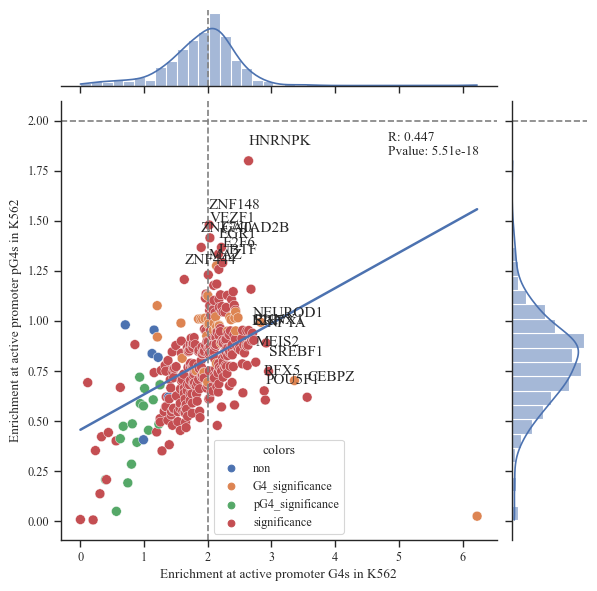

meta NOT subset; don't know how to subset; dropped


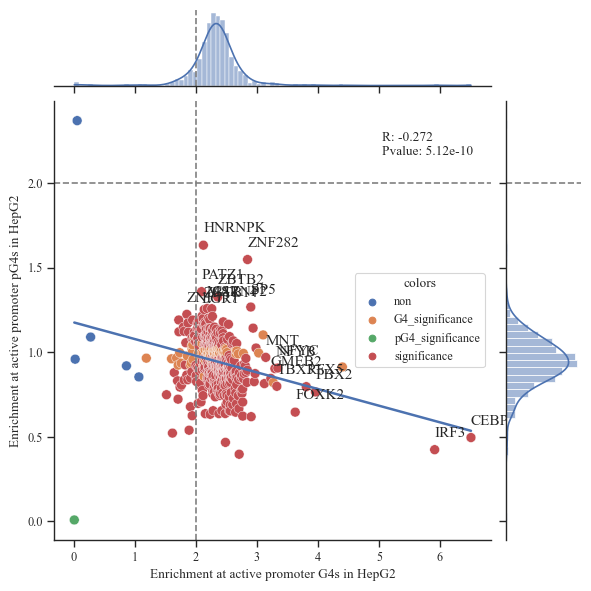

meta NOT subset; don't know how to subset; dropped


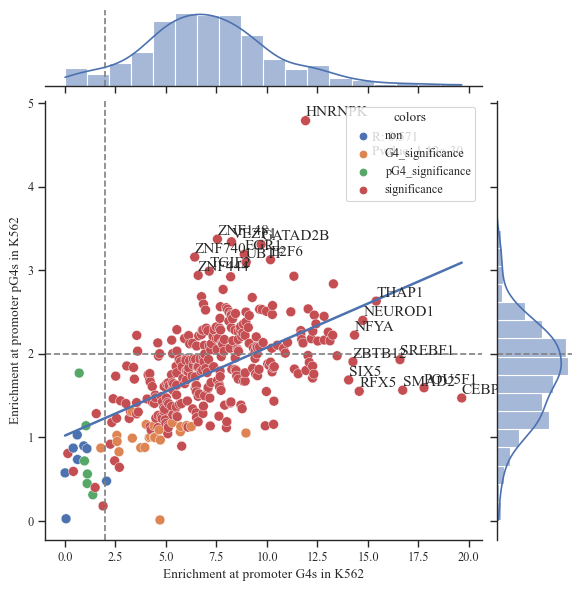

meta NOT subset; don't know how to subset; dropped


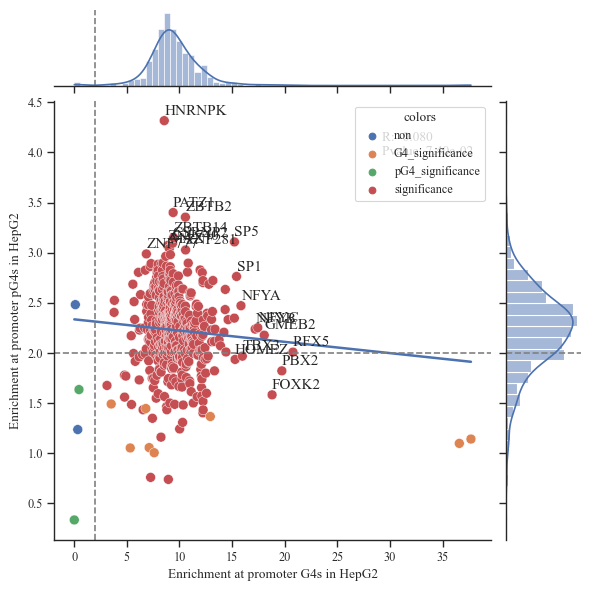

In [112]:
import os, sys, gzip
import pandas as pd
import numpy as np
import pyranges as pr
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from itertools import groupby
import re


def files_select(path):
    for p in os.listdir(path):
        if p.endswith("tsv"):
            yield pd.read_table(os.path.join(path,p),sep="\t")
def scatterplot(dat,filename,hepG2=True):
    dat["colors"] = "non"
    dat["colors"][dat["pG4_qvalue"] < 0.05] = "pG4_significance"
    dat["colors"][dat["G4_qvalue"] < 0.05] = "G4_significance"
    dat["colors"][(dat["G4_qvalue"] < 0.05) & (dat["pG4_qvalue"] < 0.05)] = "significance"
    r,p = scipy.stats.pearsonr(dat["G4_fold"],dat["pG4_fold"])
#     dat["G4_fold"] = np.log2(dat["G4_fold"])
#     dat["pG4_fold"] = np.log2(dat["pG4_fold"])
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
#     g = sns.jointplot(data=dat,x="G4_fold", y="pG4_fold",kind="reg",annot_kws=dict(stat="r"))
    g = sns.JointGrid(data=dat, x="G4_fold", y="pG4_fold")
    g.plot_joint(sns.regplot,scatter=False,ci=None)
#     sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70,hue="colors",hue_order= ["non", "significance"],ax=g.ax_joint)

    sns.scatterplot(data=dat, x="G4_fold", y="pG4_fold",s=50, hue="colors",
#                     edgecolor='colors',
                    linewidth=0.3,
#                     alpha=0.95,
                    hue_order= ["non","G4_significance", "pG4_significance","significance"],
                    ax=g.ax_joint)
    g.refline(x=2, y=2)
    g.plot_marginals(sns.histplot, kde=True)
    g.ax_joint.annotate(f'R: {r:.3f}\nPvalue: {p:.2e}', xy=(0.75,0.9),xycoords='axes fraction', ha="left",va="center")
    dat = dat.sort_values("G4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    dat = dat.sort_values("pG4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    if hepG2:
        g.set_axis_labels(xlabel="Enrichment at active promoter G4s in HepG2",ylabel="Enrichment at active promoter pG4s in HepG2")
    else:
        g.set_axis_labels(xlabel="Enrichment at active promoter G4s in K562", ylabel="Enrichment at active promoter pG4s in K562")
    plt.savefig(filename,format="pdf")
    plt.show()
def promoter_scatterplot(dat,filename,hepG2=True):
    dat["colors"] = "non"
    dat["colors"][dat["pG4_qvalue"] < 0.05] = "pG4_significance"
    dat["colors"][dat["G4_qvalue"] < 0.05] = "G4_significance"
    dat["colors"][(dat["G4_qvalue"] < 0.05) & (dat["pG4_qvalue"] < 0.05)] = "significance"
    
    r,p = scipy.stats.pearsonr(dat["G4_fold"],dat["pG4_fold"])
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
#     g = sns.jointplot(data=dat,x="G4_fold", y="pG4_fold",kind="reg",annot_kws=dict(stat="r"))
    g = sns.JointGrid(data=dat, x="G4_fold", y="pG4_fold")
    g.plot_joint(sns.regplot,scatter=False,ci=None)
#     sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70,hue="colors",hue_order= ["non", "significance"],ax=g.ax_joint)
    sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=50,hue="colors",
                    linewidth=0.3,
#                     alpha=0.95,
                    hue_order= ["non","G4_significance", "pG4_significance","significance"],ax=g.ax_joint)
#     g.plot_joint(sns.regplot)
    g.refline(x=2, y=2)
    g.plot_marginals(sns.histplot, kde=True)
    g.ax_joint.annotate(f'R: {r:.3f}\nPvalue: {p:.2e}', xy=(0.75,0.9),xycoords='axes fraction', ha="left",va="center")
    dat = dat.sort_values("G4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    dat = dat.sort_values("pG4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    if hepG2:
        g.set_axis_labels(xlabel="Enrichment at promoter G4s in HepG2",ylabel="Enrichment at promoter pG4s in HepG2")
    else:
        g.set_axis_labels(xlabel="Enrichment at promoter G4s in K562", ylabel="Enrichment at promoter pG4s in K562")
    plt.savefig(filename,format="pdf")
    plt.show()
    
wdpath = "/disk2/G4_MS/encode/analysis/TF/activePromoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/TF/active_promoter_K562_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/TF/active_promoter_K562_G4_gat"
# pG4_files = files_select(pG4_path)
# G4_files = files_select(G4_path)
pG4_result = pd.read_table(os.path.join(pG4_path,"active_promoter_K562_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"active_promoter_K562_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")
df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

scatterplot(df,os.path.join(wdpath,"K562_active_promoter_TF.pdf"),hepG2=False)
# ### HepG2 active promoter
wdpath = "/disk2/G4_MS/encode/analysis/TF/activePromoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/TF/active_promoter_HepG2_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/TF/active_promoter_HepG2_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"active_promoter_HepG2_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"active_promoter_HepG2_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")
# df.loc[:,"track"] = df.loc[:,"track"].map(lambda x: x.split(".")[0].split("_")[1])
df = df.sort_values("G4_fold")
df.reset_index(inplace=True)
# G4_result.to_csv(os.path.join(wdpath,"HepG2_active_promoter.G4.result.xls"),sep="\t",index=False)
# pG4_result.to_csv(os.path.join(wdpath,"HepG2_active_promoter.pG4.result.xls"),sep="\t",index=False)
scatterplot(df,os.path.join(wdpath,"HepG2_active_promoter_TF.pdf"),hepG2=True)
# ## K562 promoter region
wdpath = "/disk2/G4_MS/encode/analysis/TF/Promoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/TF/promoter_K562_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/TF/promoter_K562_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"promoter_K562_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"promoter_K562_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")
df = df.sort_values("G4_fold")
df.reset_index(inplace=True)
promoter_scatterplot(df,os.path.join(wdpath,"K562_promoter_TF.pdf"),hepG2=False)
# ## HepG2 promoter region
wdpath = "/disk2/G4_MS/encode/analysis/TF/Promoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/TF/promoter_HepG2_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/TF/promoter_HepG2_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"promoter_HepG2_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"promoter_HepG2_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")
# df.loc[:,"track"] = df.loc[:,"track"].map(lambda x: x.split(".")[0].split("_")[1])
df = df.sort_values("G4_fold")
df.reset_index(inplace=True)
# G4_result.to_csv(os.path.join(wdpath,"HepG2_promoter.G4.result.xls"),sep="\t",index=False)
# pG4_result.to_csv(os.path.join(wdpath,"HepG2_promoter.pG4.result.xls"),sep="\t",index=False)
promoter_scatterplot(df,os.path.join(wdpath,"HepG2_promoter_TF.pdf"),hepG2=True)

# chromotain remodeler

meta NOT subset; don't know how to subset; dropped


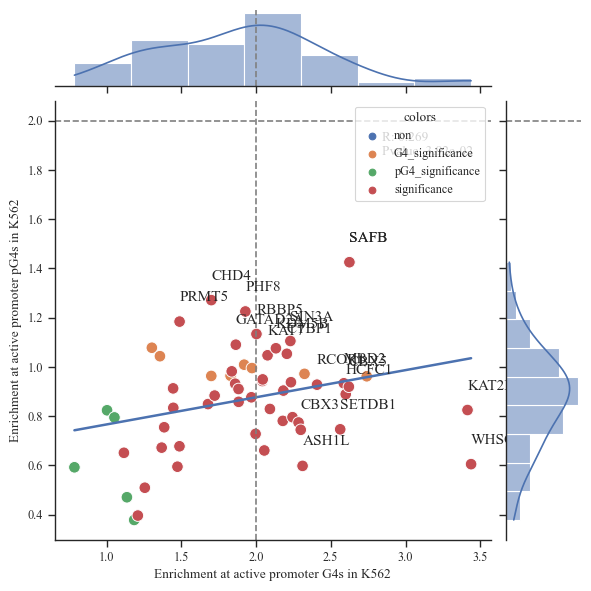

meta NOT subset; don't know how to subset; dropped


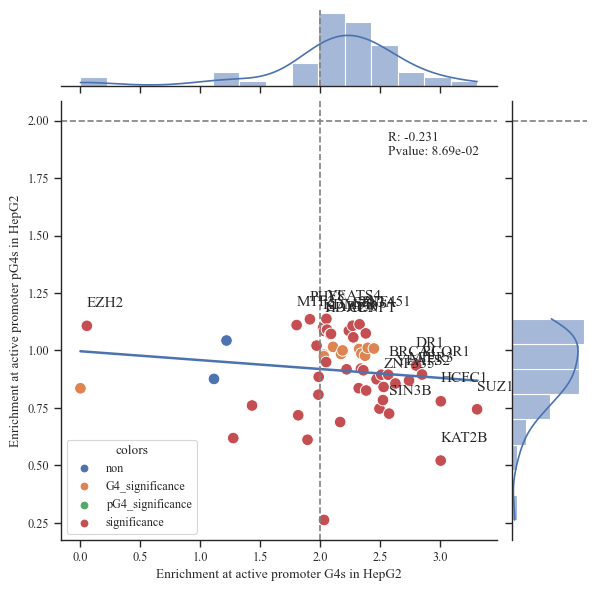

meta NOT subset; don't know how to subset; dropped


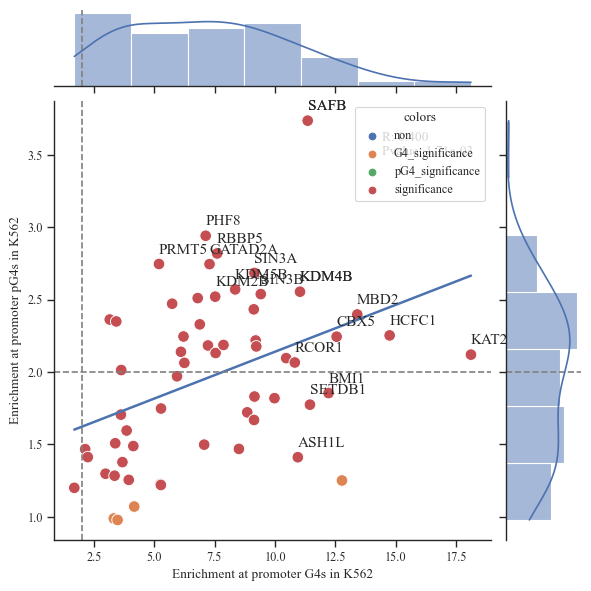

meta NOT subset; don't know how to subset; dropped


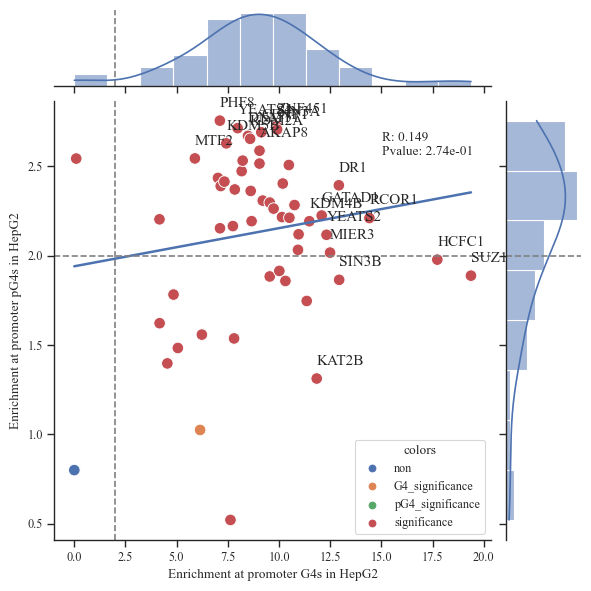

In [111]:
import os, sys, gzip
import pandas as pd
import numpy as np
import pyranges as pr
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from itertools import groupby
import re


def files_select(path):
    for p in os.listdir(path):
        if p.endswith("tsv"):
            yield pd.read_table(os.path.join(path,p),sep="\t")
def scatterplot(dat,filename,hepG2=True):
    dat["colors"] = "non"
    dat["colors"][dat["pG4_qvalue"] < 0.05] = "pG4_significance"
    dat["colors"][dat["G4_qvalue"] < 0.05] = "G4_significance"
    dat["colors"][(dat["G4_qvalue"] < 0.05) & (dat["pG4_qvalue"] < 0.05)] = "significance"
    r,p = scipy.stats.pearsonr(dat["G4_fold"],dat["pG4_fold"])
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
#     g = sns.jointplot(data=dat,x="G4_fold", y="pG4_fold",kind="reg",annot_kws=dict(stat="r"))
    g = sns.JointGrid(data=dat, x="G4_fold", y="pG4_fold")
    g.plot_joint(sns.regplot,scatter=False,ci=None)
#     sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70,hue="colors",hue_order= ["non", "significance"],ax=g.ax_joint)

    sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70,hue="colors",hue_order= ["non","G4_significance", "pG4_significance","significance"],ax=g.ax_joint)
    g.refline(x=2, y=2)
    g.plot_marginals(sns.histplot, kde=True)
    g.ax_joint.annotate(f'R: {r:.3f}\nPvalue: {p:.2e}', xy=(0.75,0.9),xycoords='axes fraction', ha="left",va="center")
    dat = dat.sort_values("G4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    dat = dat.sort_values("pG4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    if hepG2:
        g.set_axis_labels(xlabel="Enrichment at active promoter G4s in HepG2",ylabel="Enrichment at active promoter pG4s in HepG2")
    else:
        g.set_axis_labels(xlabel="Enrichment at active promoter G4s in K562", ylabel="Enrichment at active promoter pG4s in K562")
    plt.savefig(filename,format="pdf")
    plt.show()
def promoter_scatterplot(dat,filename,hepG2=True):
    dat["colors"] = "non"
    dat["colors"][dat["pG4_qvalue"] < 0.05] = "pG4_significance"
    dat["colors"][dat["G4_qvalue"] < 0.05] = "G4_significance"
    dat["colors"][(dat["G4_qvalue"] < 0.05) & (dat["pG4_qvalue"] < 0.05)] = "significance"
#     
    r,p = scipy.stats.pearsonr(dat["G4_fold"],dat["pG4_fold"])
    
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
#     g = sns.jointplot(data=dat,x="G4_fold", y="pG4_fold",kind="reg",annot_kws=dict(stat="r"))
    g = sns.JointGrid(data=dat, x="G4_fold", y="pG4_fold")
    g.plot_joint(sns.regplot,scatter=False,ci=None)
#     sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70,hue="colors",hue_order= ["non", "significance"],ax=g.ax_joint)
    sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70,hue="colors",hue_order= ["non","G4_significance", "pG4_significance","significance"],ax=g.ax_joint)
    g.refline(x=2, y=2)
    g.plot_marginals(sns.histplot, kde=True)
    g.ax_joint.annotate(f'R: {r:.3f}\nPvalue: {p:.2e}', xy=(0.75,0.9),xycoords='axes fraction', ha="left",va="center")
    dat = dat.sort_values("G4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    dat = dat.sort_values("pG4_fold")
    for index,t in dat[dat.colors=="significance"].tail(10).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        g.ax_joint.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    if hepG2:
        g.set_axis_labels(xlabel="Enrichment at promoter G4s in HepG2",ylabel="Enrichment at promoter pG4s in HepG2")
    else:
        g.set_axis_labels(xlabel="Enrichment at promoter G4s in K562", ylabel="Enrichment at promoter pG4s in K562")
    plt.savefig(filename,format="pdf")
    plt.show()
    
wdpath = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/activePromoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/active_promoter_K562_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/active_promoter_K562_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"active_promoter_K562_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"active_promoter_K562_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

scatterplot(df,os.path.join(wdpath,"K562_active_promoter_chromtain_remodeler.pdf"),hepG2=False)
### HepG2 active promoter
wdpath = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/activePromoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/active_promoter_HepG2_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/active_promoter_HepG2_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"active_promoter_HepG2_pG4_encode.tsv"))
G4_result =  pd.read_table(os.path.join(G4_path,"active_promoter_HepG2_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

scatterplot(df,os.path.join(wdpath,"HepG2_active_promoter_chromtain_remodeler.pdf"),hepG2=True)
## K562 promoter region
wdpath = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/Promoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/promoter_K562_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/promoter_K562_G4_gat"
pG4_result = pd.read_table(os.path.join(pG4_path,"promoter_K562_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"promoter_K562_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)
promoter_scatterplot(df,os.path.join(wdpath,"K562_promoter_chromtain_remodeler.pdf"),hepG2=False)
## HepG2 promoter region
wdpath = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/Promoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/promoter_HepG2_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/chromtain_remodeler/promoter_HepG2_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"promoter_HepG2_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"promoter_HepG2_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

promoter_scatterplot(df,os.path.join(wdpath,"HepG2_promoter_chromtain_remodeler.pdf"),hepG2=True)

# histone figure Drown

meta NOT subset; don't know how to subset; dropped


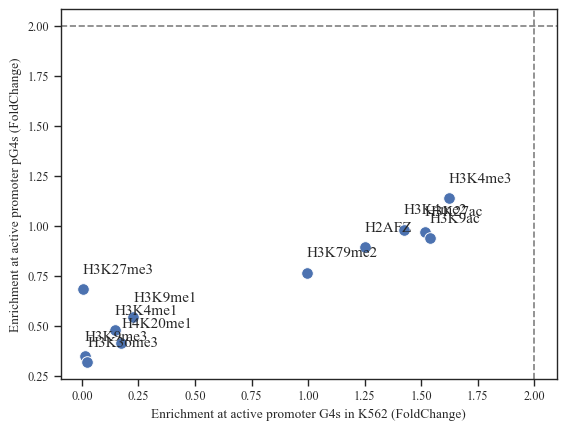

meta NOT subset; don't know how to subset; dropped


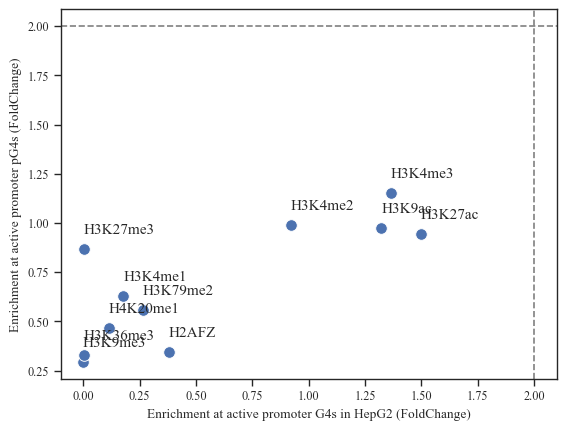

meta NOT subset; don't know how to subset; dropped


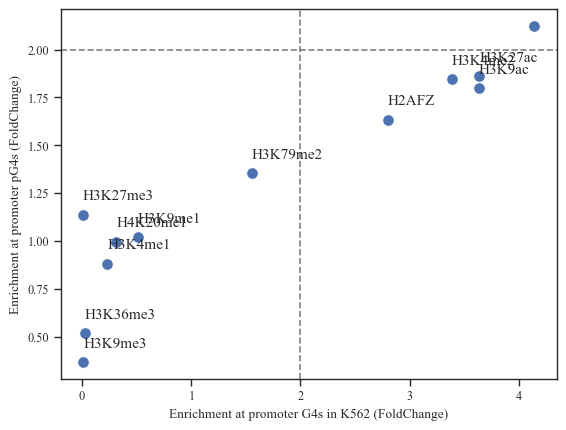

meta NOT subset; don't know how to subset; dropped


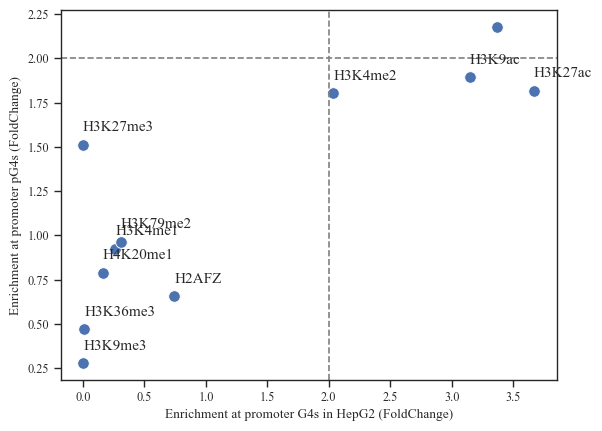

In [154]:
import os, sys, gzip
import pandas as pd
import numpy as np
import pyranges as pr
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from itertools import groupby
import re


def files_select(path):
    for p in os.listdir(path):
        if p.endswith("tsv"):
            yield pd.read_table(os.path.join(path,p),sep="\t")
def scatterplot(dat,filename,hepG2=True):
    dat["colors"] = "non"
    dat["colors"][dat["pG4_qvalue"] < 0.05] = "pG4_significance"
    dat["colors"][dat["G4_qvalue"] < 0.05] = "G4_significance"
    dat["colors"][(dat["G4_qvalue"] < 0.05) & (dat["pG4_qvalue"] < 0.05)] = "significance"

    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
    fig, ax = plt.subplots()
    sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70)
    plt.axhline(y=2, color="grey", linestyle = "--")
    plt.axvline(x=2, color="grey", linestyle = "--")
    dat = dat.sort_values("G4_fold")
#     for index,t in dat.tail(10).iterrows():
#         x,y,z = t.G4_fold,t.pG4_fold,t.annotation
#         plt.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
#     dat = dat.sort_values("pG4_fold")
    for index,t in dat.tail(20).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        plt.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    if hepG2: 
        ax.set_xlabel("Enrichment at active promoter G4s in HepG2 (FoldChange)")
        ax.set_ylabel("Enrichment at active promoter pG4s (FoldChange)")
#         sns.set_axis_labels(xlabel="Enrichment at active promoter G4s in HepG2\n(FoldChange)",ylabel="Enrichment at active promoter pG4s (FoldChange)")
    else:
        ax.set_xlabel("Enrichment at active promoter G4s in K562 (FoldChange)")
        ax.set_ylabel("Enrichment at active promoter pG4s (FoldChange)")
#         sns.set_axis_labels(xlabel="Enrichment at active promoter G4s in K562\n(FoldChange)", ylabel="Enrichment at active promoter pG4s (FoldChange)")
    plt.savefig(filename,format="pdf")
    plt.show()
def promoter_scatterplot(dat,filename,hepG2=True):
    dat["colors"] = "non"
    dat["colors"][dat["pG4_qvalue"] < 0.05] = "pG4_significance"
    dat["colors"][dat["G4_qvalue"] < 0.05] = "G4_significance"
    dat["colors"][(dat["G4_qvalue"] < 0.05) & (dat["pG4_qvalue"] < 0.05)] = "significance"
#     
    
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
#fig, ax = plt.subplots()
    fig, ax = plt.subplots()
    sns.scatterplot(data=dat,  x="G4_fold", y="pG4_fold",s=70)
    plt.axhline(y=2, color="grey", linestyle = "--")
    plt.axvline(x=2, color="grey", linestyle = "--")
    dat = dat.sort_values("G4_fold")
    
#     for index,t in dat.tail(10).iterrows():
#         x,y,z = t.G4_fold,t.pG4_fold,t.annotation
#         plt.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    dat = dat.sort_values("pG4_fold")
    for index,t in dat.tail(20).iterrows():
        x,y,z = t.G4_fold,t.pG4_fold,t.annotation
        plt.annotate(z,xy=(x,y+0.1),ha="left",va="center",fontsize=11)
    if hepG2: 
        ax.set_xlabel("Enrichment at promoter G4s in HepG2 (FoldChange)")
        ax.set_ylabel("Enrichment at promoter pG4s (FoldChange)")
#         sns.set_axis_labels(xlabel="Enrichment at active promoter G4s in HepG2\n(FoldChange)",ylabel="Enrichment at active promoter pG4s (FoldChange)")
    else:
        ax.set_xlabel("Enrichment at promoter G4s in K562 (FoldChange)")
        ax.set_ylabel("Enrichment at promoter pG4s (FoldChange)")
        
    plt.savefig(filename,format="pdf")
    plt.show()
    
wdpath = "/disk2/G4_MS/encode/analysis/histone/activePromoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/histone/active_promoter_K562_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/histone/active_promoter_K562_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"active_promoter_K562_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"active_promoter_K562_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

scatterplot(df,os.path.join(wdpath,"K562_active_promoter_histone.pdf"),hepG2=False)
### HepG2 active promoter
wdpath = "/disk2/G4_MS/encode/analysis/histone/activePromoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/histone/active_promoter_HepG2_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/histone/active_promoter_HepG2_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"active_promoter_HepG2_pG4_encode.tsv"))
G4_result =  pd.read_table(os.path.join(G4_path,"active_promoter_HepG2_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

scatterplot(df,os.path.join(wdpath,"HepG2_active_promoter_histone.pdf"),hepG2=True)
## K562 promoter region
wdpath = "/disk2/G4_MS/encode/analysis/histone/Promoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/histone/promoter_K562_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/histone/promoter_K562_G4_gat"
pG4_result = pd.read_table(os.path.join(pG4_path,"promoter_K562_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"promoter_K562_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)
promoter_scatterplot(df,os.path.join(wdpath,"K562_promoter_histone.pdf"),hepG2=False)
## HepG2 promoter region
wdpath = "/disk2/G4_MS/encode/analysis/histone/Promoter_result"
pG4_path = "/disk2/G4_MS/encode/analysis/histone/promoter_HepG2_pG4_gat"
G4_path = "/disk2/G4_MS/encode/analysis/histone/promoter_HepG2_G4_gat"

pG4_result = pd.read_table(os.path.join(pG4_path,"promoter_HepG2_pG4_encode.tsv"))
G4_result = pd.read_table(os.path.join(G4_path,"promoter_HepG2_G4_encode.tsv"))
pG4_drow_fig_result = pG4_result.loc[:,["annotation","fold","qvalue"]]
pG4_drow_fig_result.rename(columns={"fold":"pG4_fold","qvalue":"pG4_qvalue"},inplace=True)
G4_drow_fig_result = G4_result.loc[:,["annotation","fold","qvalue"]]
G4_drow_fig_result.rename(columns={"fold":"G4_fold","qvalue":"G4_qvalue"},inplace=True)
df = pG4_drow_fig_result.merge(G4_drow_fig_result,on="annotation")

df = df.sort_values("G4_fold")
df.reset_index(inplace=True)

promoter_scatterplot(df,os.path.join(wdpath,"HepG2_promoter_histone.pdf"),hepG2=True)